# Solution

In [19]:
# put all python import statements here
from solvers import solver
import numpy as np
import matplotlib.pyplot as plt
from solvers import solver
from tabulate import tabulate
import time

## Implementation

[*Write code to be able to run three methods you have chosen for arbitrary initial conditions ($x(t=0), y(t=0)$), time step ($\mathrm{d}t$), model parameters ($\alpha, \beta, \gamma, \delta$) and functions $f$ and $g$. [50 words]*]

In [66]:

def rhs(t, u):
    alpha = 1
    beta = 1
    gamma = 1
    delta = 1
    f = lambda t: -np.sin(t) - np.cos(t)**2 - np.cos(t)
    g = lambda t: np.sin(t) + np.cos(t)**2 - np.cos(t)

    dx_dt = alpha * u[0] - beta * u[0] * u[1] + f(t)
    dy_dt = delta * u[0] * u[1] - gamma * u[1] + g(t)

    return np.array([dx_dt, dy_dt])

def modified_newton_method(rhs, u0, t0, dt, T, tol=1e-6, max_iter=100, epsilon=1e-8):
    t_out = [t0]
    x = u0
    x_out = [x.copy()]

    def numerical_jacobian(t, x):
        n = len(x)
        J = np.zeros((n, n))

        for i in range(n):
            x_perturbed = x.copy()
            x_perturbed[i] += epsilon
            fx_perturbed = rhs(t, x_perturbed)
            J[:, i] = (fx_perturbed - rhs(t, x)) / epsilon

        return J

    for _ in range(int(T / dt)):
        fx = rhs(t_out[-1], x)
        Jx = numerical_jacobian(t_out[-1], x)
        delta_x = np.linalg.solve(Jx, -fx)
        x = x + delta_x

        t_new = t_out[-1] + dt
        t_out.append(t_new)
        x_out.append(x.copy())


    return t_out, x_out
    return t_out, x_out


def run_simulation(u0, T, time_steps, methods):
    total_times = {method: [] for method in methods}
    line_positions = np.arange(len(time_steps))

    for dt_factor in time_steps:
        dt = T / dt_factor

        for method in methods:
            start_time = time.time()
            if method == "Modified-Newton":
                t, sol = modified_newton_method(rhs, u0, 0, dt, T)
            else:
                t, sol = solver(rhs, u0, 0, dt, T, method)
            end_time = time.time()

            total_time = end_time - start_time
            total_times[method].append(total_time)

    return total_times

time_steps = [100, 200, 400, 800, 1600]
methods = ["Heun", "Runge-Kutta", "Modified-Newton"]

# Test Case A
T = 2.5 * np.pi
u0 = np.array([2.0, 0.0]) # x0 = 2, y0 = 0

# Run the simulation and get total times
total_times_A = run_simulation(u0, T, time_steps, methods)

## Results

[*Simulate and show results for each of the test cases suggested by your boss for a range of time steps until a final time $T$.
For test case A, you should use $T = 2.5\pi$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
For test case B, you should use $T = 30$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
You should demonstrate how solutions look for each method, and the accuracy and efficiency of each approach. [50 words]*]



Results for Heun:
dt = T/100, Total Time = 0.005456 s
+---------------------+-----------------------+----------------------+
| Time/2.5π  (s/2.5π) |          (x)          |         (y)          |
+---------------------+-----------------------+----------------------+
|       (0/100)       |          2.0          |         0.0          |
|       (1/100)       |  1.9972817134040186   | 0.002960398638418289 |
|       (2/100)       |  1.9884663615066651   | 0.01205708617534262  |
|       (3/100)       |   1.973611730705161   | 0.027235634129529087 |
|       (4/100)       |  1.9528118517131001   | 0.048405170731133026 |
|       (5/100)       |  1.9261960619843892   | 0.07543911444969265  |
|       (6/100)       |  1.8939278483542124   | 0.10817608868670181  |
|       (7/100)       |  1.8562035115123299   |  0.146420982710053   |
|       (8/100)       |   1.813250703032639   | 0.18994612050027881  |
|       (9/100)       |  1.7653268911594713   | 0.23849249993452085  |
|      (10/100)       |

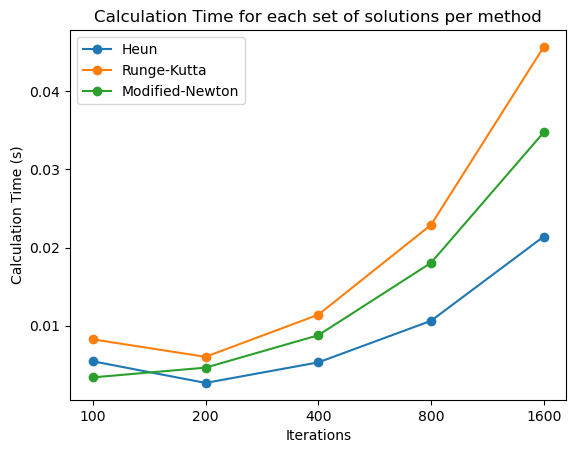

In [67]:
# Display results in a separate section
for method in methods:
    print(f"Results for {method}:")
    for dt_factor, times in zip(time_steps_A, total_times_A[method]):
        print(f"dt = T/{dt_factor}, Total Time = {times:.6f} s")
        
        # Convert sol_ref to a NumPy array
        if method == "Modified-Newton":
            t_ref, sol_ref = modified_newton_method(rhs, u0, 0, T_A / dt_factor, T_A)
        else:
            t_ref, sol_ref = solver(rhs, u0, 0, T_A / dt_factor, T_A, method)
        sol_ref = np.array(sol_ref)

        # Display results in a table
        formatted_t = ["({}/{})".format(int(ti / (T_A / dt_factor)), int(2.5 * np.pi / (T_A / dt_factor))) for ti in t_ref]
        table_data = list(zip(formatted_t, sol_ref[:, 0], sol_ref[:, 1]))

        # Print the table
        table = tabulate(table_data, headers=['Time/2.5π  (s/2.5π)', '(x)', '(y)'], tablefmt='pretty')
        print(table)
        print("\n" + "=" * 50 + "\n")  # Separate charts and tables with a line

# Create line chart for total times
plt.figure()
for method in methods:
    plt.plot(line_positions, total_times_A[method], marker='o', label=method)

plt.title("Calculation Time for each set of solutions per method")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (s)")
plt.xticks(line_positions, [f'{dt_factor}' for dt_factor in time_steps_A])
plt.legend()
plt.show()

## Analysis

[*Comment on the efficiency and accuracy of each approach. [250 words]*]

## Conclusion

[*Compare the methods that you have results for, and any other relevant methods from the module, and make a recommendation of which method you think is best. [300 words]*]